## An introduction to the Materials Project API

The Materials Project is an open database of computed and experimental materials information, maintained by the Lawrence Berkeley National Laboratory. It provides crystal structures, thermodynamic data, electronic properties, and more for over 150,000 inorganic compounds. By exposing this wealth of data through a programmable interface, the Materials Project API lets you:

- Query compositions and properties (e.g. band gaps, formation energies, elastic tensors) directly from Python or any HTTP client.
- Download crystal structures in formats like CIF or POSCAR for further analysis.
- Build phase diagrams, compute Pourbaix diagrams, or fetch provenance metadata for data-quality tracking.

Because most entries arise from density functional theory (DFT) calculations, it’s important to bear in mind the usual DFT caveats—absolute energies may shift by tenths of an eV, and band gaps are typically underestimated. However, for exploring trends across chemical families, screening candidate materials, or automating data-driven workflows, the API is an indispensable tool.

### Getting started: your API key

1. Create a free account at https://materialsproject.org.
2. After logging in, navigate to My Dashboard → API Key to reveal your personal key.
3. Enter it in the cell below

# Querying the materials project and simulating diffraction data

In [1]:
API_KEY = "YOUR_API_KEY"  # Replace with your Materials Project API key

We can queury lots of different information about the materials on there, just be mindful that it is all theoretical data, and while much of the information in there is useful, we should always treat it with caution, as it is done with highthroughput one-size-fits-all calculations, many systems require bespoke approaches to model accurately. Take the data with a pinch of salt, but trends should be useful!

In [2]:
# 1. Import the client
from mp_api.client import MPRester

# 2. Open a connection using your already-loaded API_KEY
with MPRester(API_KEY) as mpr:
    # Ask the summary endpoint what fields you can request
    available_fields = mpr.materials.summary.available_fields

# 3. Show the result as a simple numbered list
print("Materials Project summary fields you can query:\n")
for i, field in enumerate(available_fields, start=1):
    print(f"{i}. {field}")

Materials Project summary fields you can query:

1. builder_meta
2. nsites
3. elements
4. nelements
5. composition
6. composition_reduced
7. formula_pretty
8. formula_anonymous
9. chemsys
10. volume
11. density
12. density_atomic
13. symmetry
14. property_name
15. material_id
16. deprecated
17. deprecation_reasons
18. last_updated
19. origins
20. warnings
21. structure
22. task_ids
23. uncorrected_energy_per_atom
24. energy_per_atom
25. formation_energy_per_atom
26. energy_above_hull
27. is_stable
28. equilibrium_reaction_energy_per_atom
29. decomposes_to
30. xas
31. grain_boundaries
32. band_gap
33. cbm
34. vbm
35. efermi
36. is_gap_direct
37. is_metal
38. es_source_calc_id
39. bandstructure
40. dos
41. dos_energy_up
42. dos_energy_down
43. is_magnetic
44. ordering
45. total_magnetization
46. total_magnetization_normalized_vol
47. total_magnetization_normalized_formula_units
48. num_magnetic_sites
49. num_unique_magnetic_sites
50. types_of_magnetic_species
51. bulk_modulus
52. shear_m

/Users/alex/anaconda3/envs/work/lib/python3.10/site-packages/mp_api/client/mprester.py:230: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Explanation for Python beginners

- **Import**: bring in the MPRester class from the new mp_api package.
- **Connect**: use a with–block so Python automatically closes the connection when you’re done.
- **Query**: `mpr.materials.summary.available_fields` returns a Python list of strings—each one is a property you can ask for when searching the Materials Project. You can see there is a lot of stuff in there!
- **Print**: we loop over that list and print each field with a number in front so it’s easy to read.

Now on to a nice and simple example! Let's find some data for NaCl, starting with the phase diagram.

In [3]:
from mp_api.client import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

# 1. Define your chemical system (here: Na–Cl)
chemsys = ["Na", "Cl", "Na-Cl"]

# 2. Connect and fetch only experimentally observed Na–Cl entries
with MPRester(API_KEY) as mpr:
    # We ask for material_id and check for theoretical entries
    # Theoretical entries are those that are not experimentally observed
    # We filter out theoretical entries by checking the 'theoretical' field.
    # Here we do this just for simplicities sake and to see how we can filter entries.
    docs = mpr.materials.summary.search(
        chemsys=chemsys,
        fields=["material_id", "theoretical"]
    )
    exp_ids = [d.material_id for d in docs if d.theoretical is False] # Filter out theoretical entries

# 3. Download full entry data for those IDs, these entries contain all the information we need
# to build the phase diagram
with MPRester(API_KEY) as mpr:
    exp_entries = mpr.get_entries(exp_ids)

# 4. Build and show the phase diagram
pd_exp = PhaseDiagram(exp_entries)
plotter = PDPlotter(pd_exp)
plotter.show()

Retrieving SummaryDoc documents:   0%|          | 0/33 [00:00<?, ?it/s]

Retrieving ThermoDoc documents:   0%|          | 0/31 [00:00<?, ?it/s]

### What happens here?

- **Chemical system definition**: We specify Na–Cl via chemsys.
- **Filtering for experiment**: We pull material_id and theoretical, then keep only those where theoretical is False, so in this simple example there won't be any strange computational predictions!
- **Data retrieval**: We fetch full ComputedEntry objects for these IDs, this contains many of the calculated properties of the experimental Na-Cl phases
- **Phase diagram**: Having recovered the entries we compute and display the convex hull phase diagram!

We can recover the structures from the entries, and then manipulate and analyse these structures, e.g. predict their XRD patterns, which is what we will do next, using [pymatgen](https://pymatgen.org/), the code that powers the materials project. 

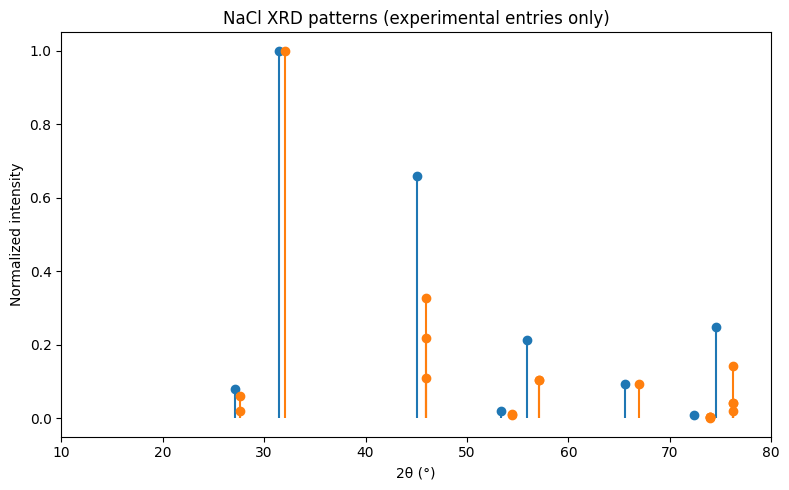

In [4]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute XRD patterns 
# Initialize the XRD calculator using Cu Kα radiation (λ ≈ 1.5406 Å)
xrd_calc = XRDCalculator(wavelength="CuKa")
entries = [e for e in exp_entries if e.reduced_formula == "NaCl"]
patterns = [xrd_calc.get_pattern(e.structure) for e in entries]

# Define colors manually if needed
colors = ["C0", "C1"]

# 2. Extract energy per atom for labeling (not used for alpha anymore)
energies = np.array([e.energy_per_atom for e in entries])

# 3. Plot using stem() with uniform opacity
plt.figure(figsize=(8, 5))
for pat, epa, color in zip(patterns, energies, colors):
    markerline, stemlines, baseline = plt.stem(
        pat.x,
        pat.y / pat.y.max(),  # normalize intensity
        basefmt=" "           # hide baseline
    )
    plt.setp(markerline, color=color)
    plt.setp(stemlines, color=color)

plt.xlabel("2θ (°)")
plt.ylabel("Normalized intensity")
plt.title("NaCl XRD patterns (experimental entries only)")
plt.xlim(10, 80)
plt.tight_layout()
plt.show()

for entry in entries:
    spacegroup = entry.structure.get_space_group_info()[1]
    entry.structure.to(filename=f"{entry.reduced_formula}_{spacegroup}.cif")


Here we can see there are two entries for the NaCl composition, one, the expected Rocksalt structure, what's the other? It's experimentally observed, what conditions does it exist under? See if you can find some experimental data to compare to to work out which is which.

### ZnS

This example fetches materials in the Zn–S chemical system from the Materials Project API, then builds the phase diagram. If you "zoom in" on the 50:50 composition structure, we can see that there are many low energy structures that are likely experimentally observable. ZnS has at least two polymorphs, zincblende and wurtzite. Lets see if we can pull these out and work out which is which, will it be as simple as NaCl? 


In [5]:
from mp_api.client import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

# 1. Query Zn–S chemical system entries from the Materials Project
with MPRester(API_KEY) as mpr:
    # Fetch material_id and whether each entry is theoretical (not observed experimentally)
    docs = mpr.materials.summary.search(
        chemsys=["Zn", "S", "Zn-S"],        # Include both elemental and binary compositions
        fields=["theoretical", "material_id"]
    )

# 2. Split the results into:
#    - docs_exp: entries that are NOT theoretical (i.e. have experimental support)
#    - docs_all: all entries (experimental + theoretical)
docs_all = [d.material_id for d in docs]


all_entries = mpr.get_entries(docs_all)    # All available entries

# 5. Build and show the phase diagram including theoretical (predicted) structures
pd = PhaseDiagram(all_entries)
plotter = PDPlotter(pd)
plotter.show()


/Users/alex/anaconda3/envs/work/lib/python3.10/site-packages/mp_api/client/mprester.py:230: UserWarning:

mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'



Retrieving SummaryDoc documents:   0%|          | 0/186 [00:00<?, ?it/s]

Retrieving ThermoDoc documents:   0%|          | 0/463 [00:00<?, ?it/s]

Looking at this phase diagram, we can see that there are actually many more structures that are on the materials project! Following the same procedure as we did for NaCl to predict the diffraction patterns, here we can see that there are many many predicted XRD patterns for ZnS, as it is much more prone to polymorphism that NaCl.

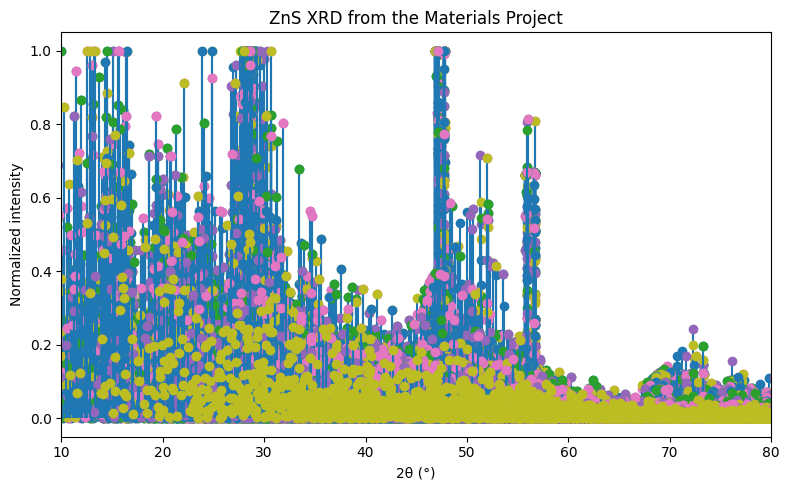

In [6]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute XRD patterns
# Initialize the XRD calculator using Cu Kα radiation (λ ≈ 1.5406 Å)
xrd_calc = XRDCalculator(wavelength="CuKa")

# Filter only the entries with reduced formula ZnS from a preloaded list `all_entries`
entries = [e for e in all_entries if e.reduced_formula == "ZnS"]

# Compute XRD patterns (2θ positions and intensities) for each ZnS structure
patterns = [xrd_calc.get_pattern(e.structure) for e in entries]

# 2. Plot the results using a stem plot for discrete peaks
plt.figure(figsize=(8, 5))  # Set up plot dimensions

# Loop through each pattern and draw stems at each 2θ peak with normalized intensity
for pat in patterns:
    markerline, stemlines, baseline = plt.stem(
        pat.x,
        pat.y / pat.y.max(),  # Normalize intensities to max = 1
        basefmt=" ",          # Remove baseline formatting
        linefmt="-",          # Line style for stems
        markerfmt="o",        # Marker style for peaks
    )
    # Optionally adjust styling here, e.g., markerline.set_alpha(0.8)

# Add axis labels and figure title
plt.xlabel("2θ (°)")
plt.ylabel("Normalized intensity")
plt.title(f"ZnS XRD from the Materials Project")
plt.xlim(10, 80)  # Typical range for Cu Kα diffraction
plt.tight_layout()
plt.show()  # Render the figure


A visulisation nightmare! We can try and clean this up to see what a "realistic" XRD pattern might look like for ZnS by utilizing the data available in the materials project: weighting the structures by their energies. The Boltzmann factor α = exp(−ΔE / kBT) gives the relative probability of each structure by boltzmann weighting the data 

### Boltzmann Weighting Explained

The Boltzmann factor  

$$\alpha = \exp\left(-\frac{\Delta E}{k_B T}\right)$$

gives the relative probability of observing each structure at thermal equilibrium.

- **Low-energy structures** (ΔE ≈ 0) have α ≈ 1 and contribute strongly.
- **Higher-energy structures** are exponentially suppressed and contribute less.

This is used to modulate the transparency (alpha) of each structure’s XRD peaks in the plot, effectively downweighting less stable configurations.

The temperature `T` acts as a smoothing parameter:
- At **T → 0 K**, only the ground state contributes (α → 0 for all others).
- At **higher T**, metastable structures are included in proportion to their thermal likelihood.

This approach visually communicates the thermodynamic relevance of each phase.

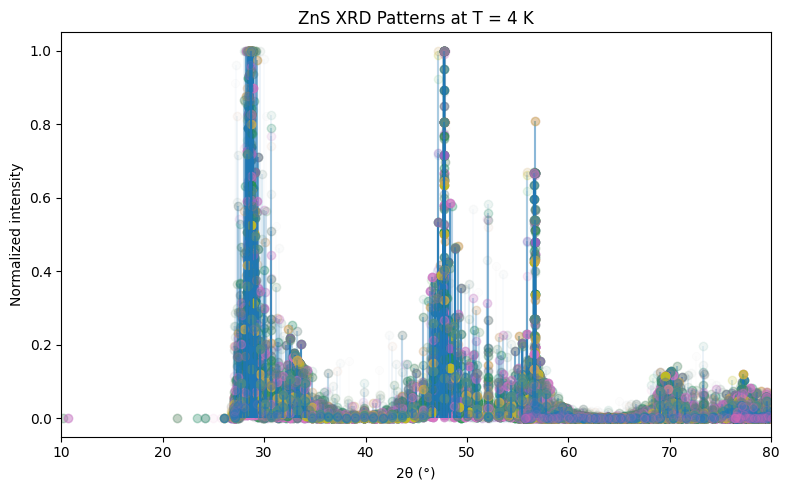

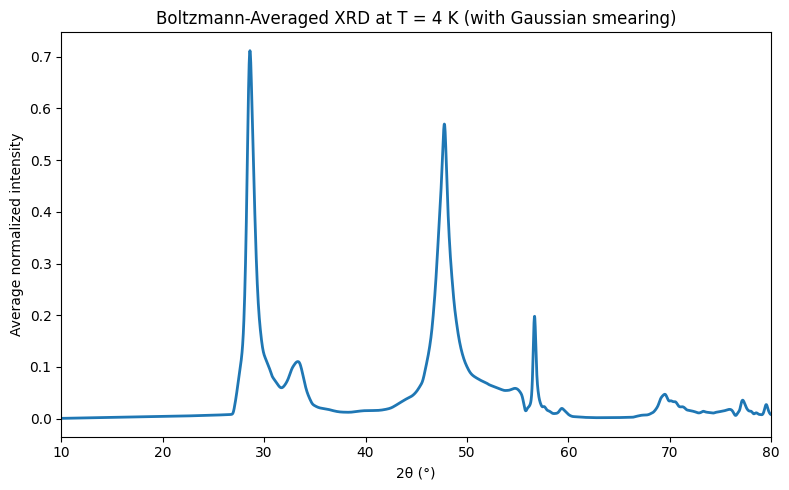

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute energy differences relative to ground state
energies = np.array([e.energy_per_atom for e in entries])
delta_e = energies - energies.min()

# 2. Boltzmann weighting
# -----------------------
# The Boltzmann factor:
#     α = exp(−ΔE / kBT)
# represents the relative probability of each structure at temperature T.
# Structures with lower ΔE are more likely to be observed.
# We use α to modulate the transparency of each XRD pattern in the plot.
#
# T acts as a smoothing parameter:
#   - T → 0 K: only the ground state matters (α → 0 for others)
#   - Higher T: metastable phases contribute proportionally
k_B = 8.617333262e-5  # Boltzmann constant in eV/K
T = 4             # Temperature in K
kBT = k_B * T
alphas = np.exp(-delta_e / kBT)

# Normalize Boltzmann weights to sum to 1 for averaging
boltz_weights = alphas / alphas.sum()

# 3. Plot all XRD patterns with transparency based on Boltzmann factor
plt.figure(figsize=(8, 5))
for pat, alpha in zip(patterns, alphas):
    markerline, stemlines, baseline = plt.stem(
        pat.x,
        pat.y / pat.y.max(),  # normalize each pattern to max intensity 1
        basefmt=" ",
        linefmt="-",
        markerfmt="o",
    )
    plt.setp(markerline, alpha=alpha)
    plt.setp(stemlines, alpha=alpha)

plt.xlabel("2θ (°)")
plt.ylabel("Normalized intensity")
plt.title(f"ZnS XRD Patterns at T = {T:.0f} K")
plt.xlim(10, 80)
plt.tight_layout()
plt.show()

from scipy.ndimage import gaussian_filter1d

# 4. Compute and plot Boltzmann-weighted average XRD with smearing
# -----------------------------------------------------------------
x_min, x_max = 10, 80
x_grid = np.linspace(x_min, x_max, 3500)
y_sum = np.zeros_like(x_grid)

# Interpolate and weight each pattern
for pat, weight in zip(patterns, boltz_weights):
    interp = np.interp(x_grid, pat.x, pat.y / pat.y.max(), left=0, right=0)
    y_sum += weight * interp

# Apply Gaussian smearing to the total
# sigma is in grid points, not degrees; increase for broader peaks
smeared_y = gaussian_filter1d(y_sum, sigma=5)

# Plot average XRD
plt.figure(figsize=(8, 5))
plt.plot(x_grid, smeared_y, lw=2)
plt.xlabel("2θ (°)")
plt.ylabel("Average normalized intensity")
plt.title(f"Boltzmann-Averaged XRD at T = {T:.0f} K (with Gaussian smearing)")
plt.xlim(10, 80)
plt.tight_layout()
plt.show()

Look for some experimental XRD data for ZnS and see if we're picking up the same peaks!

A final challenge: using the materials project API can you see how many allotropes of carbon you can identify? 

In [ ]:
# 2. Connect and fetch only experimentally observed Na–Cl entries
with MPRester(API_KEY) as mpr:
    # We ask for material_id and check for theoretical entries
    # Theoretical entries are those that are not experimentally observed
    # We filter out theoretical entries by checking the 'theoretical' field.
    # Here we do this just for simplicities sake and to see how we can filter entries.
    docs = mpr.materials.summary.search(
        chemsys=["C"],
        fields=["material_id", "theoretical"]
    )
    exp_ids = [d.material_id for d in docs if d.theoretical is False] # Filter out theoretical entries